In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input,Rescaling,Conv2D, MaxPooling2D,Activation,GlobalAveragePooling2D,SpatialDropout2D,Flatten, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:

IMG_SIZE = (128, 128)
BATCH_SIZE = 8
EPOCHS = 60
VALIDATION_SPLIT = 0.1
BASE_PATH = 'dataset'
MEASUREMENT_COLS = [
    'ankle', 'arm-length', 'bicep', 'calf', 'chest', 'forearm', 
    'height', 'hip', 'leg-length', 'shoulder-breadth',
    'shoulder-to-crotch', 'thigh', 'waist', 'wrist'
]


In [3]:
def load_and_clean_data():
    metadata = pd.read_csv(os.path.join(BASE_PATH, 'train', 'hwg_metadata.csv'))
    measurements = pd.read_csv(os.path.join(BASE_PATH, 'train', 'measurements.csv'))
    photo_map = pd.read_csv(os.path.join(BASE_PATH, 'train', 'subject_to_photo_map.csv'))

    linked_data = photo_map.merge(
        metadata[['subject_id', 'gender', 'height_cm', 'weight_kg']],
        on='subject_id',
        how='inner'
    ).merge(
        measurements,
        on='subject_id',
        how='inner'
    )
    
    linked_data = linked_data.drop_duplicates(subset=['subject_id'])
    linked_data = linked_data.dropna(subset=['photo_id', 'subject_id'])
    linked_data = linked_data[linked_data.photo_id.str.match(r'^[a-f0-9]{32}$')]
    linked_data['gender'] = linked_data['gender'].map({'male': 0, 'female': 1})
    MEASUREMENT_COLS = measurements.columns.drop('subject_id').tolist()
    linked_data['measurements'] = linked_data[MEASUREMENT_COLS].values.tolist()
    final_df = linked_data[['photo_id', 'gender', 'height_cm', 'weight_kg', 'measurements']]
    return final_df

In [4]:
def load_image_data(data_df):
    front_images = []
    side_images = []
    meta_data = []
    measurements = []

    for _, row in data_df.iterrows():
        try:
            front_img = load_img(os.path.join(BASE_PATH, 'train', 'mask', f"{row['photo_id']}.png"),
                               color_mode='grayscale', target_size=IMG_SIZE)
            side_img = load_img(os.path.join(BASE_PATH, 'train', 'mask_left', f"{row['photo_id']}.png"),
                              color_mode='grayscale', target_size=IMG_SIZE)

            front_array = img_to_array(front_img) / 255.0
            side_array = img_to_array(side_img) / 255.0

            front_images.append(front_array)
            side_images.append(side_array)
            meta_data.append([row['gender'], row['height_cm'], row['weight_kg']])
            measurements.append(row['measurements'])
        except Exception as e:
            continue

    return (
        np.array(front_images, dtype=np.float32),
        np.array(side_images, dtype=np.float32),
        np.array(meta_data, dtype=np.float32),
        np.array(measurements, dtype=np.float32)
    )

In [11]:
def create_dual_input_model(measurement_cols):
    front_input = Input(shape=(*IMG_SIZE, 1), name='front_image')
    side_input = Input(shape=(*IMG_SIZE, 1), name='side_image')
    meta_input = Input(shape=(3,), name='metadata')

    def create_image_branch(input_layer):
        x = Rescaling(1./255)(input_layer)
        x = Conv2D(32, (3,3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SpatialDropout2D(0.2)(x)  
        x = MaxPooling2D(2,2)(x)

        
        x = Conv2D(64, (3,3), padding='same', kernel_regularizer='l2')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SpatialDropout2D(0.3)(x)
        x = MaxPooling2D(2,2)(x)

        return GlobalAveragePooling2D()(x)

    front_features = create_image_branch(front_input)
    side_features = create_image_branch(side_input)

    merged_images = Concatenate()([front_features, side_features])
    combined = Concatenate()([merged_images, meta_input])

    x = Dense(512, activation='relu', 
              kernel_regularizer=l2(0.01),  
              bias_regularizer=l2(0.01))(combined)
    x = Dropout(0.6)(x)  
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', 
              kernel_regularizer=l2(0.01),  
              bias_regularizer=l2(0.01))(x)
    x = Dropout(0.6)(x)  

    measurements_output = Dense(len(measurement_cols),
                                activation='linear',
                                name='measurements')(x)

    model = Model(
        inputs=[front_input, side_input, meta_input],
        outputs=measurements_output
    )
    
    model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.00005,  
        clipvalue=0.5  
    ),
    loss='mse',
    metrics=['mae']
    )
    
    return model

In [6]:
def get_training_callbacks():
    return [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
    ]

Epoch 1/60
205/205 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step - loss: 5674.9922 - mae: 62.7988 - val_loss: 5683.9194 - val_mae: 62.8206 - learning_rate: 5.0000e-05
Epoch 2/60
205/205 ━━━━━━━━━━━━━━━━━━━━ 37s 182ms/step - loss: 5483.9150 - mae: 61.2921 - val_loss: 5513.6626 - val_mae: 61.6205 - learning_rate: 5.0000e-05
Epoch 3/60
205/205 ━━━━━━━━━━━━━━━━━━━━ 37s 182ms/step - loss: 5132.9355 - mae: 58.6033 - val_loss: 4916.4282 - val_mae: 57.0114 - learning_rate: 5.0000e-05
Epoch 4/60
205/205 ━━━━━━━━━━━━━━━━━━━━ 37s 182ms/step - loss: 4634.2549 - mae: 54.4180 - val_loss: 4393.1675 - val_mae: 52.4100 - learning_rate: 5.0000e-05
Epoch 5/60
205/205 ━━━━━━━━━━━━━━━━━━━━ 37s 181ms/step - loss: 3850.5964 - mae: 47.1574 - val_loss: 3314.1902 - val_mae: 41.7666 - learning_rate: 5.0000e-05
Epoch 6/60
205/205 ━━━━━━━━━━━━━━━━━━━━ 37s 182ms/step - loss: 2824.2920 - mae: 36.8301 - val_loss: 2080.4927 - val_mae: 28.9957 - learning_rate: 5.0000e-05
Epoch 7/60
205/205 ━━━━━━━━━━━━━━━━━━━━ 38s 183ms/step - l

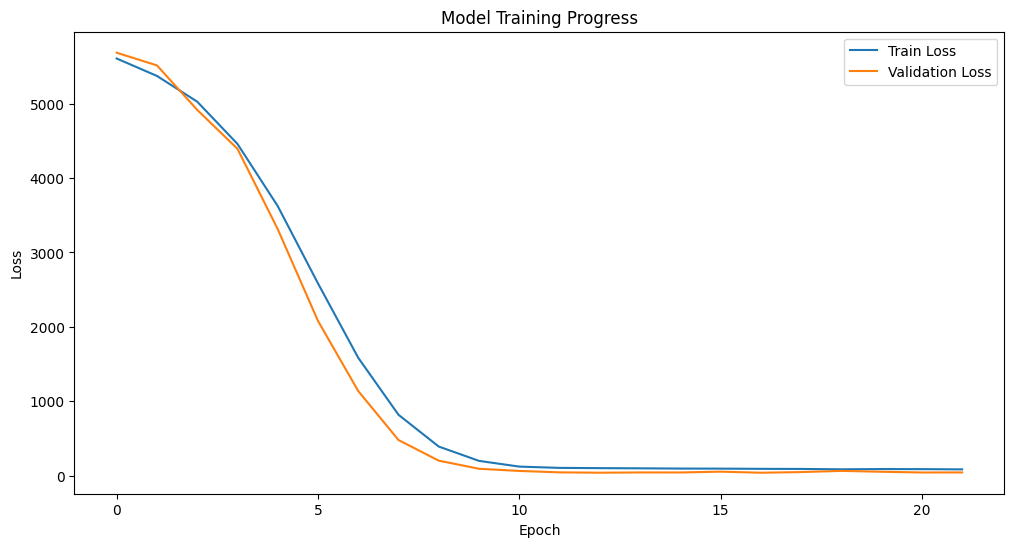

In [12]:
if __name__ == "__main__":
    cleaned_data = load_and_clean_data()
    front_imgs, side_imgs, meta_data, measurements = load_image_data(cleaned_data)
    
    (X_front_train, X_front_test, 
     X_side_train, X_side_test,
     X_meta_train, X_meta_test,
     y_meas_train, y_meas_test) = train_test_split(
        front_imgs, side_imgs, meta_data, measurements,
        test_size=VALIDATION_SPLIT, random_state=15
    )

    model = create_dual_input_model(MEASUREMENT_COLS)
    
    history = model.fit(
        x=[X_front_train, X_side_train, X_meta_train],
        y=y_meas_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        callbacks=get_training_callbacks()
    )

 
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training Progress')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()